In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, RobustScaler
from pyspark.sql.functions import when
from pyspark.ml.functions import vector_to_array

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/15 16:53:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data Loading

In [3]:
df = spark.read.option('escape','"').csv('kickstarter_cleaned.csv', header=True, inferSchema=True, mode="DROPMALFORMED")
df = df.dropna()
df = df.drop("name","backers","pledged")

In [4]:
df = df.withColumn("state", when(df.state == "failed",0) \
      .when(df.state == "successful",1))
df.printSchema()

root
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- state: integer (nullable = true)
 |-- goal: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- time_interval: integer (nullable = true)
 |-- length_of_title: integer (nullable = true)
 |-- use_of_?!: integer (nullable = true)
 |-- continent: string (nullable = true)



In [5]:
(trainingData, testData) = df.randomSplit([0.7, 0.3])

# Data preparation for classification

In [6]:
categorical_cols = ["category","main_category", "currency", "year", "month", "day_of_week", "continent", "use_of_?!"]
numerical_cols = ["goal", "time_interval", "length_of_title"]

#create the indexer for the strings columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]

num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
scaler = RobustScaler(inputCol="features", outputCol="scaled_features")
assembler_all = VectorAssembler(inputCols=["features"] + [col+"_index" for col in categorical_cols], outputCol="final_features")

In [7]:
pipeline = Pipeline(stages=indexers + [num_assembler, scaler, assembler_all])
pipeline_model = pipeline.fit(trainingData)
trainingData = pipeline_model.transform(trainingData).select("final_features", "state")

In [8]:
testData = pipeline_model.transform(testData).select("final_features", "state")

# Classification

In [9]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

## DecisionTreeClassifier

In [10]:
dt = DecisionTreeClassifier(labelCol="state", featuresCol="final_features",maxBins=159)

param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [10,15,20]) \
    .addGrid(dt.minInstancesPerNode, [60,80,100]) \
    .addGrid(dt.impurity, ["gini","entropy"]) \
    .build()



#Evaluator used for the cross validation
evaluator = MulticlassClassificationEvaluator(labelCol="state", metricName="accuracy")
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=4) 

In [11]:
%%time
cv_model = crossval.fit(trainingData)

23/12/15 16:55:47 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB
23/12/15 16:55:47 WARN DAGScheduler: Broadcasting large task binary with size 1027.2 KiB
23/12/15 16:55:48 WARN DAGScheduler: Broadcasting large task binary with size 1038.3 KiB
23/12/15 16:55:57 WARN DAGScheduler: Broadcasting large task binary with size 1015.8 KiB
23/12/15 16:57:55 WARN DAGScheduler: Broadcasting large task binary with size 1006.5 KiB
23/12/15 16:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1029.6 KiB
23/12/15 16:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1038.5 KiB
23/12/15 16:58:04 WARN DAGScheduler: Broadcasting large task binary with size 1009.5 KiB
23/12/15 16:58:05 WARN DAGScheduler: Broadcasting large task binary with size 1029.6 KiB
23/12/15 17:00:11 WARN DAGScheduler: Broadcasting large task binary with size 1014.0 KiB
23/12/15 17:00:11 WARN DAGScheduler: Broadcasting large task binary with size 1035.5 KiB
23/12/15 17:00:14 WAR

CPU times: user 3.01 s, sys: 866 ms, total: 3.87 s
Wall time: 9min 23s


In [12]:
predictions = cv_model.transform(testData)

best_model = cv_model.bestModel
print("Best hyperparameters:")
print(f"Max Depth: {best_model.getMaxDepth()}")
print(f"Min Instances Per Node: {best_model.getMinInstancesPerNode()}")
print(f"Impurity: {best_model.getImpurity()}")

Best hyperparameters:
Max Depth: 15
Min Instances Per Node: 100
Impurity: gini


In [13]:
preds = predictions.select('prediction','state').rdd.map(lambda row: (float(row['prediction']), float(row['state'])))
# Instantiate metrics object

area_under_roc = BinaryClassificationMetrics(preds).areaUnderROC
metrics = MulticlassMetrics(preds)

# Overall statistics
print("Summary Stats")
print("Accuracy = %s" % metrics.accuracy)
print("Precision = %s" % metrics.precision(1.0))
print("Recall = %s" % metrics.recall(1.0))
print("F-measure = %s" % metrics.fMeasure(1.0))
print(f"Area under ROC = %s"% area_under_roc)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Summary Stats


Accuracy = 0.6733529257835302
Precision = 0.6127743320610687
Recall = 0.5135060846098103
F-measure = 0.558765549588743
Area under ROC = 0.6473309084637551


In [14]:
#Collect feature importance scores
feature_importance_scores = best_model.featureImportances.toArray().tolist()

#Rename the numerical columns
original_numerical_indices = [num_assembler.getInputCols().index(feature) for feature in numerical_cols]

#Mapping original numerical feature names to importance scores
original_numerical_importance_dict = dict(zip(numerical_cols, [feature_importance_scores[i] for i in original_numerical_indices]))


#Rename the categorical columns (e.g. year_index -> year)
original_categorical_indices = [assembler_all.getInputCols().index(feature + "_index") for feature in categorical_cols]

#Mmapping original categorical feature names to importance scores
original_categorical_importance_dict = dict(zip(categorical_cols, [feature_importance_scores[i] for i in original_categorical_indices]))

#Print numerical feature importance scores
print("Numerical Feature Importance Scores:")
for feature, importance in sorted(original_numerical_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

#Print categorical feature importance scores
print("\nCategorical Feature Importance Scores:")
for feature, importance in sorted(original_categorical_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

Numerical Feature Importance Scores:
goal: 0.33150411110626543
time_interval: 0.1232256016511175
length_of_title: 0.0659026799294873

Categorical Feature Importance Scores:
currency: 0.31638482156341036
category: 0.1232256016511175
year: 0.08528310573596351
main_category: 0.0659026799294873
day_of_week: 0.04266792946980381
continent: 0.01822660332340987
use_of_?!: 0.009427326210632645
month: 0.005009175271349305


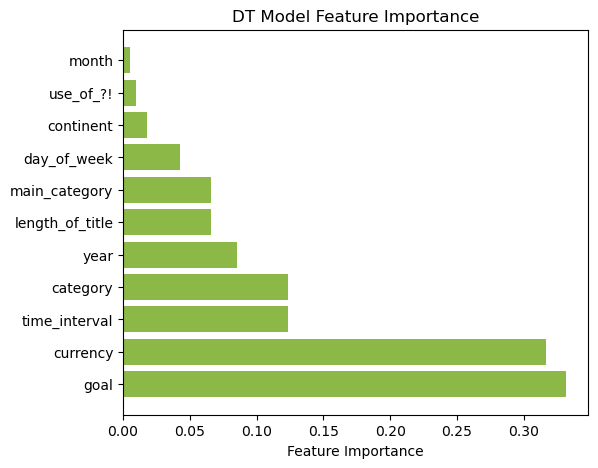

In [15]:
#Combine numerical and categorical importance
all_importance_dict = {**original_numerical_importance_dict, **original_categorical_importance_dict}

#Sort features by importance
sorted_features = sorted(all_importance_dict.items(), key=lambda x: x[1], reverse=True)

#Extract feature names and importance scores for plotting
features, importance_scores = zip(*sorted_features)

plt.figure(figsize=(6, 5))
plt.barh(range(len(features)), importance_scores, align='center',color="#8cb847")
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.tick_params(axis='y', labelsize=10)
plt.title('DT Model Feature Importance')
plt.show()

## Random forest

In [16]:
rf = RandomForestClassifier(labelCol="state", featuresCol="final_features",maxBins=159)


param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [30,40,50]) \
    .addGrid(rf.maxDepth, [2,3,4]) \
    .build()


evaluator = MulticlassClassificationEvaluator(labelCol="state", metricName="accuracy")
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=4) 

In [17]:
%%time
cv_model = crossval.fit(trainingData)

CPU times: user 2.49 s, sys: 633 ms, total: 3.13 s
Wall time: 7min 35s


In [18]:
predictions = cv_model.transform(testData)
best_model = cv_model.bestModel
print("Best hyperparameters:")
print(f"Max Depth: {best_model.getMaxDepth()}")
print(f"Num Trees: {best_model.getNumTrees}")

Best hyperparameters:
Max Depth: 4
Num Trees: 50


In [19]:
preds = predictions.select('prediction','state').rdd.map(lambda row: (float(row['prediction']), float(row['state'])))
# Instantiate metrics object

area_under_roc = BinaryClassificationMetrics(preds).areaUnderROC
metrics = MulticlassMetrics(preds)

# Overall statistics
print("Summary Stats")
print("Accuracy = %s" % metrics.accuracy)
print("Precision = %s" % metrics.precision(1.0))
print("Recall = %s" % metrics.recall(1.0))
print("F-measure = %s" % metrics.fMeasure(1.0))
print(f"Area under ROC = %s"% area_under_roc)

Summary Stats


Accuracy = 0.6503955393627086
Precision = 0.6210087498282102
Recall = 0.3387390989280092
F-measure = 0.4383650239296339
Area under ROC = 0.5996599149908926


In [20]:
#Collect feature importance scores
feature_importance_scores = best_model.featureImportances.toArray().tolist()

#Rename the numerical columns
original_numerical_indices = [num_assembler.getInputCols().index(feature) for feature in numerical_cols]

#Mapping original numerical feature names to importance scores
original_numerical_importance_dict = dict(zip(numerical_cols, [feature_importance_scores[i] for i in original_numerical_indices]))


#Rename the categorical columns (e.g. year_index -> year)
original_categorical_indices = [assembler_all.getInputCols().index(feature + "_index") for feature in categorical_cols]

#Mmapping original categorical feature names to importance scores
original_categorical_importance_dict = dict(zip(categorical_cols, [feature_importance_scores[i] for i in original_categorical_indices]))

#Print numerical feature importance scores
print("Numerical Feature Importance Scores:")
for feature, importance in sorted(original_numerical_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

#Print categorical feature importance scores
print("\nCategorical Feature Importance Scores:")
for feature, importance in sorted(original_categorical_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

Numerical Feature Importance Scores:
goal: 0.3889083305046366
time_interval: 0.14080109273099167
length_of_title: 0.04332169402164317

Categorical Feature Importance Scores:
currency: 0.2904662320868559
category: 0.14080109273099167
year: 0.10301381956356631
main_category: 0.04332169402164317
day_of_week: 0.0292611339095357
month: 0.004192844579385815
continent: 3.485260338488664e-05
use_of_?!: 0.0


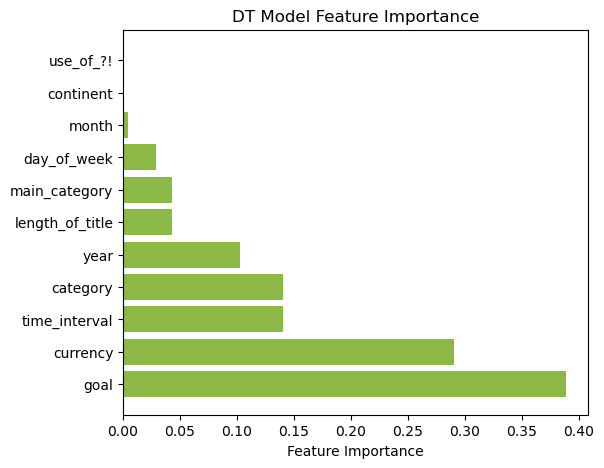

In [21]:
#Combine numerical and categorical importance
all_importance_dict = {**original_numerical_importance_dict, **original_categorical_importance_dict}

#Sort features by importance
sorted_features = sorted(all_importance_dict.items(), key=lambda x: x[1], reverse=True)

#Extract feature names and importance scores for plotting
features, importance_scores = zip(*sorted_features)

plt.figure(figsize=(6, 5))
plt.barh(range(len(features)), importance_scores, align='center',color="#8cb847")
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.tick_params(axis='y', labelsize=10)
plt.title('DT Model Feature Importance')
plt.show()